In [39]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from ogs6py.ogs import OGS
import vtuIO

In [40]:
dir_th2m_constpGR = "../model_10/febex/TH2M_const_pGR"
dir_th2m = "../model_10/febex/TH2M"
dir_trm = "../model_10/febex/TRM"

In [41]:
specific_latent_heat = 2258000
#vapour_diffusion = 6.15e-6
heat_power = 53.38511519711004

In [42]:
path = "/home/buchwalj/github/build_master/bin"

In [43]:
os.chdir(f"{dir_th2m}")

m = OGS(INPUT_FILE="run_10_TH2M.prj", PROJECT_FILE="out.prj")
m.replace_parameter_value(name="Qvalue", value=heat_power)
lhs = m.tree.findall("./media/medium/phases/phase[type='Gas']/components/component/properties/property[name='specific_latent_heat']/value")
for lh in lhs:
    lh.text = str(specific_latent_heat)
#for i in range(5):
#    m.replace_phase_property_value(mediumid=i,phase="Gas", component="W", name="diffusion", value=vapour_diffusion)
m.set(output_prefix=f"TH2M_run_10")
m.write_input()
m.run_model(path=path, args="-o results")

os.chdir(f"../../{dir_th2m_constpGR}")
m = OGS(INPUT_FILE="run_10_TH2M_const_pGR.prj", PROJECT_FILE="out.prj")
m.replace_parameter_value(name="Qvalue", value=heat_power)
lhs = m.tree.findall("./media/medium/phases/phase[type='Gas']/components/component/properties/property[name='specific_latent_heat']/value")
for lh in lhs:
    lh.text = str(specific_latent_heat)
#for i in range(5):
#    m.replace_phase_property_value(mediumid=i,phase="Gas", component="W", name="diffusion", value=vapour_diffusion)
m.set(output_prefix=f"TH2M_const_pGR_run_10")
m.write_input()
m.run_model(path=path, args="-o results")

os.chdir(f"../../{dir_trm}")
m = OGS(INPUT_FILE="run_10_TRM.prj", PROJECT_FILE="out.prj")
m.replace_parameter_value(name="Qvalue", value=heat_power)
for i in range(5):
    #m.replace_phase_property_value(mediumid=i,phase="Gas", name="diffusion", value=vapour_diffusion)
    m.replace_phase_property_value(mediumid=i,phase="Gas", name="specific_latent_heat", value=specific_latent_heat)
m.set(output_prefix="TRM_run_10")
m.write_input()
m.run_model(path=path, args="-o results")


os.chdir("../../../notebook/")


OGS finished with project file out.prj.
Execution took 89.8718810081482 s
Project file written to output.
OGS finished with project file out.prj.
Execution took 89.35494565963745 s
Project file written to output.
OGS finished with project file out.prj.
Execution took 20.67625594139099 s
Project file written to output.


In [44]:

pvdfile_th2m_const_pGR = vtuIO.PVDIO("../model_10/febex/TH2M_const_pGR/results/TH2M_run_10_const_pGR.pvd", dim=2)
time_th2m_const = pvdfile_th2m_const_pGR.timesteps

pvdfile_th2m = vtuIO.PVDIO("../model_10/febex/TH2M/results/TH2M_run_10.pvd", dim=2)
time_th2m = pvdfile_th2m.timesteps

pvdfile_trm = vtuIO.PVDIO("../model_10/febex/TRM/results/TRM_run_10.pvd", dim=2)
time_trm = pvdfile_trm.timesteps

pvdfile_trm_nolh = vtuIO.PVDIO("../model_10/febex/TRM/results/TRM_run_10_nolh.pvd", dim=2)
time_trm_nolh = pvdfile_trm_nolh.timesteps

In [45]:
print('TH2M_const', time_th2m_const[-1])
print('TH2M', time_th2m[-1])
print('TRM', time_trm[-1])

TH2M_const 473040000.0
TH2M 473040000.0
TRM 473040000.0


In [46]:
pts = {
"H1": (0.1575,0,0),
"H2": (0.42,0,0),
"GBM1": (0.590625,0,0),
"GBM2": (0.9625,0,0),
"GBM3": (1.35625,0,0),
"SC1": (1.43,0,0),
"SC2": (1.5,0,0),
"SC3": (1.58,0,0),
"EDZ1": (1.63,0,0),
"EDZ2": (1.7,0,0),
"EDZ3": (1.78,0,0),
"OPA1": (1.83,0,0),
"OPA2": (2,0,0),
"OPA3": (5,0,0),
"OPA4": (20,0,0),
"OPA5": (30,0,0),
"OPA6": (40,0,0),
"OPA7": (50,0,0)
}

pt_keys = ["H1", "H2", "GBM1", "GBM2", "GBM3", "SC1", "SC2", "SC3", "EDZ1", "EDZ2", "EDZ3", "OPA1", "OPA2", "OPA3", "OPA4", "OPA5", "OPA6", "OPA7"]

def p_map(pt):
    if "GBM" in pt:
        return 0
    elif "SC" in pt or "EDZ" in pt:
        return 1
    elif "OPA" in pt:
        return 2

In [47]:
result_variables_th2m = ["temperature","gas_pressure","capillary_pressure",
                    "saturation", "liquid_density"]
result_variables_trm = ["temperature","pressure","saturation", "liquid_density"]

In [48]:
results_th2m = pvdfile_th2m.read_time_series(result_variables_th2m, pts=pts)
results_th2m_const = pvdfile_th2m_const_pGR.read_time_series(result_variables_th2m, pts=pts)
results_trm = pvdfile_trm.read_time_series(result_variables_trm, pts=pts)
results_trm_nolh = pvdfile_trm_nolh.read_time_series(result_variables_trm, pts=pts)

In [49]:
# relative Humidity RH from Kelvin-Laplace eq.

# RH = exp(-pCap*MW/rhoLR/R/T)

MW = 0.1801528
R = 8.31446261815324

RH_th2m = {}
RH_th2m_const = {}
RH_trm = {}
RH_trm_nolh = {}

for loc in results_th2m_const:
    T = results_th2m_const[loc]["temperature"]
    pCap = results_th2m_const[loc]["capillary_pressure"]
    rhoLR = results_th2m_const[loc]["liquid_density"]
    RH_th2m_const[loc] = np.exp(-pCap*MW/rhoLR/R/T)

for loc in results_th2m:
    T = results_th2m[loc]["temperature"]
    pCap = results_th2m[loc]["capillary_pressure"]
    rhoLR = results_th2m[loc]["liquid_density"]
    RH_th2m[loc] = np.exp(-pCap*MW/rhoLR/R/T)

for loc in results_trm:
    T = results_trm[loc]["temperature"]
    pCap = -results_trm[loc]["pressure"]
    rhoLR = results_trm[loc]["liquid_density"]
    RH_trm[loc] = np.exp(-pCap*MW/rhoLR/R/T)

for loc in results_trm_nolh:
    T = results_trm_nolh[loc]["temperature"]
    pCap = -results_trm_nolh[loc]["pressure"]
    rhoLR = results_trm_nolh[loc]["liquid_density"]
    RH_trm_nolh[loc] = np.exp(-pCap*MW/rhoLR/R/T)

In [50]:
from matplotlib.backends.backend_pdf import PdfPages

def seconds_to_years(seconds):
    return seconds / 365.2425 / 86400
def seconds_to_days(seconds):
    return seconds / 86400
def days_to_seconds(days):
    return days * 86400

def plot_page(t_min, t_max, var, log=False):
    y_label="default"
    if var=="temperature":
        th2m = {loc: results_th2m[loc][var]-273.15 for loc in results_th2m}
        th2m_cp = {loc: results_th2m_const[loc][var]-273.15 for loc in results_th2m_const}
        trm = {loc: results_trm[loc][var]-273.15 for loc in results_trm}
        trm_nolh = {loc: results_trm_nolh[loc][var]-273.15 for loc in results_trm}
        y_label = "$T$ / $^\circ$C"
        #print("th2m_const", len(th2m_cp), "time_th2m_const", len(time_th2m_const))
        #print("th2m", len(th2m), "time_th2m", len(time_th2m))        
    if var=="saturation":
        th2m = {loc: results_th2m[loc][var] for loc in results_th2m}
        th2m_cp = {loc: results_th2m_const[loc][var] for loc in results_th2m_const}
        trm = {loc: results_trm[loc][var] for loc in results_trm}
        trm_nolh = {loc: results_trm_nolh[loc][var] for loc in results_trm_nolh}
        y_label = "$s_\\mathrm{L}$ / 1"
    if var=="gas_pressure":
        th2m = {loc: results_th2m[loc][var]*1e-6 for loc in results_th2m}
        th2m_cp = {loc: results_th2m_const[loc][var]*1e-6 for loc in results_th2m_const}
        trm = {loc: results_trm[loc]["pressure"]*0+0.1 for loc in results_trm}
        trm_nolh = {loc: results_trm_nolh[loc]["pressure"]*0+0.1 for loc in results_trm_nolh}
        y_label = "$p_\\mathrm{GR}$ / MPa"
    if var=="liquid_pressure":
        th2m = {loc: (results_th2m[loc]["gas_pressure"]-results_th2m[loc]["capillary_pressure"])*1.e-6 for loc in results_th2m}
        th2m_cp = {loc: (results_th2m_const[loc]["gas_pressure"]-results_th2m_const[loc]["capillary_pressure"])*1e-6 for loc in results_th2m_const}
        trm = {loc: results_trm[loc]["pressure"]*1.e-6 for loc in results_trm}
        trm_nolh = {loc: results_trm_nolh[loc]["pressure"]*1.e-6 for loc in results_trm_nolh}
        y_label = "$p_\\mathrm{LR}$ / MPa"
    if var=="liquid_density":
        th2m = {loc: results_th2m[loc][var] for loc in results_th2m}
        th2m_cp = {loc: results_th2m_const[loc][var] for loc in results_th2m_const}
        trm = {loc: results_trm[loc][var] for loc in results_trm}
        trm_nolh = {loc: results_trm_nolh[loc][var] for loc in results_trm_nolh}
        y_label = "$_\\mathrm{LR}$ / MPa"
    if var=="relative_humidity":
        th2m = RH_th2m
        th2m_cp = RH_th2m_const
        trm = RH_trm
        trm_nolh = RH_trm_nolh
        y_label = "$RH$"
    if var=="capillary_pressure":
        th2m = {loc: (results_th2m[loc]["capillary_pressure"])*1.e-6 for loc in results_th2m}
        th2m_cp = {loc: (results_th2m_const[loc]["capillary_pressure"])*1e-6 for loc in results_th2m_const}
        trm = {loc: results_trm[loc]["pressure"]*-1.e-6 for loc in results_trm}
        trm_nolh = {loc: results_trm_nolh[loc]["pressure"]*-1.e-6 for loc in results_trm_nolh}
        y_label = "$p_\\mathrm{cap}$ / MPa"        
        
    pdf_pages = PdfPages(var+".pdf")
    #fig = plt.figure(figsize=(8, 2))
    #plt.text(0.5, 0.5, "My Simulation Results", fontsize=16, ha='center', va='center')
    #plt.axis('off')
    #pdf_pages.savefig(fig)
    
    
    columns = 3
    rows = 6
    subfig_width = 5
    subfig_height = 3
    
    
    fig, axs = plt.subplots(nrows=rows, ncols=columns, 
                            figsize=(columns*subfig_width, rows*subfig_height), sharex=False)
 

    # Set the x-axis limits for all subplots
    for ax in axs.flat:
        ax.set_xlim(t_min,t_max)

    for r in range(rows):
        for c in range(columns):
            index = r*columns+c
            key = pt_keys[index]
            #print(r,c,index, key, pts[key])
            #print(f"TH2M max T {key}:", np.max(th2m[key]))
            #print(f"TH2M const max T {key}:", np.max(th2m_cp[key]))
            #print(f"TRM max T {key}:", np.max(trm[key]))
            #print(f"TRM nolh max T {key}:", np.max(trm_nolh[key]))
            axs[r,c].plot(time_th2m/86400, th2m[key], color = 'blue', linestyle='--', label='TH2M') # plot the current data set in the current subplot
            axs[r,c].plot(time_trm/86400, trm[key],color='red', linestyle='--',label='TRM') # plot the current data set in the current subplot
            axs[r,c].plot(time_trm_nolh/86400, trm_nolh[key],color='black', linestyle='--',label='TRM nolh') # plot the current data set in the current subplot
            axs[r,c].plot(time_th2m_const/86400, th2m_cp[key], color='green', linestyle=':', lw=2 ,label='TH2M-const p$_\mathrm{GR}$') # plot the current data set in the current subplot
            axs[r,c].set_title(key,  fontweight='bold', fontstyle='italic') # set the title of the current subplot
  
 
    # Linestyles: '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    
    for i in range(rows):
        axs[i,0].set_ylabel(y_label) # set the title of the current subplot
    for i in range(columns):
        axs[rows-1,i].set_xlabel("time / days") # set the title of the current subplot
        #x_ticks = axs[rows-1, i].get_xticks()
        #axs[rows-1,i].set_xticklabels([f"{seconds_to_days(t):.1f}" for t in x_ticks])
        #axs[rows-1,i].set_xlim(t_min,t_max)
    
    axs[0, 0].legend()    
            
    fig.subplots_adjust(wspace=0.2, hspace=0.3)  # increase the spacing between subplots


    # Save the subplots to the PDF file
    pdf_pages.savefig(fig)

    # Close the PdfPages object to finalize the PDF file
    pdf_pages.close()
    

In [51]:
np.max(results_th2m[loc]["temperature"])

290.15

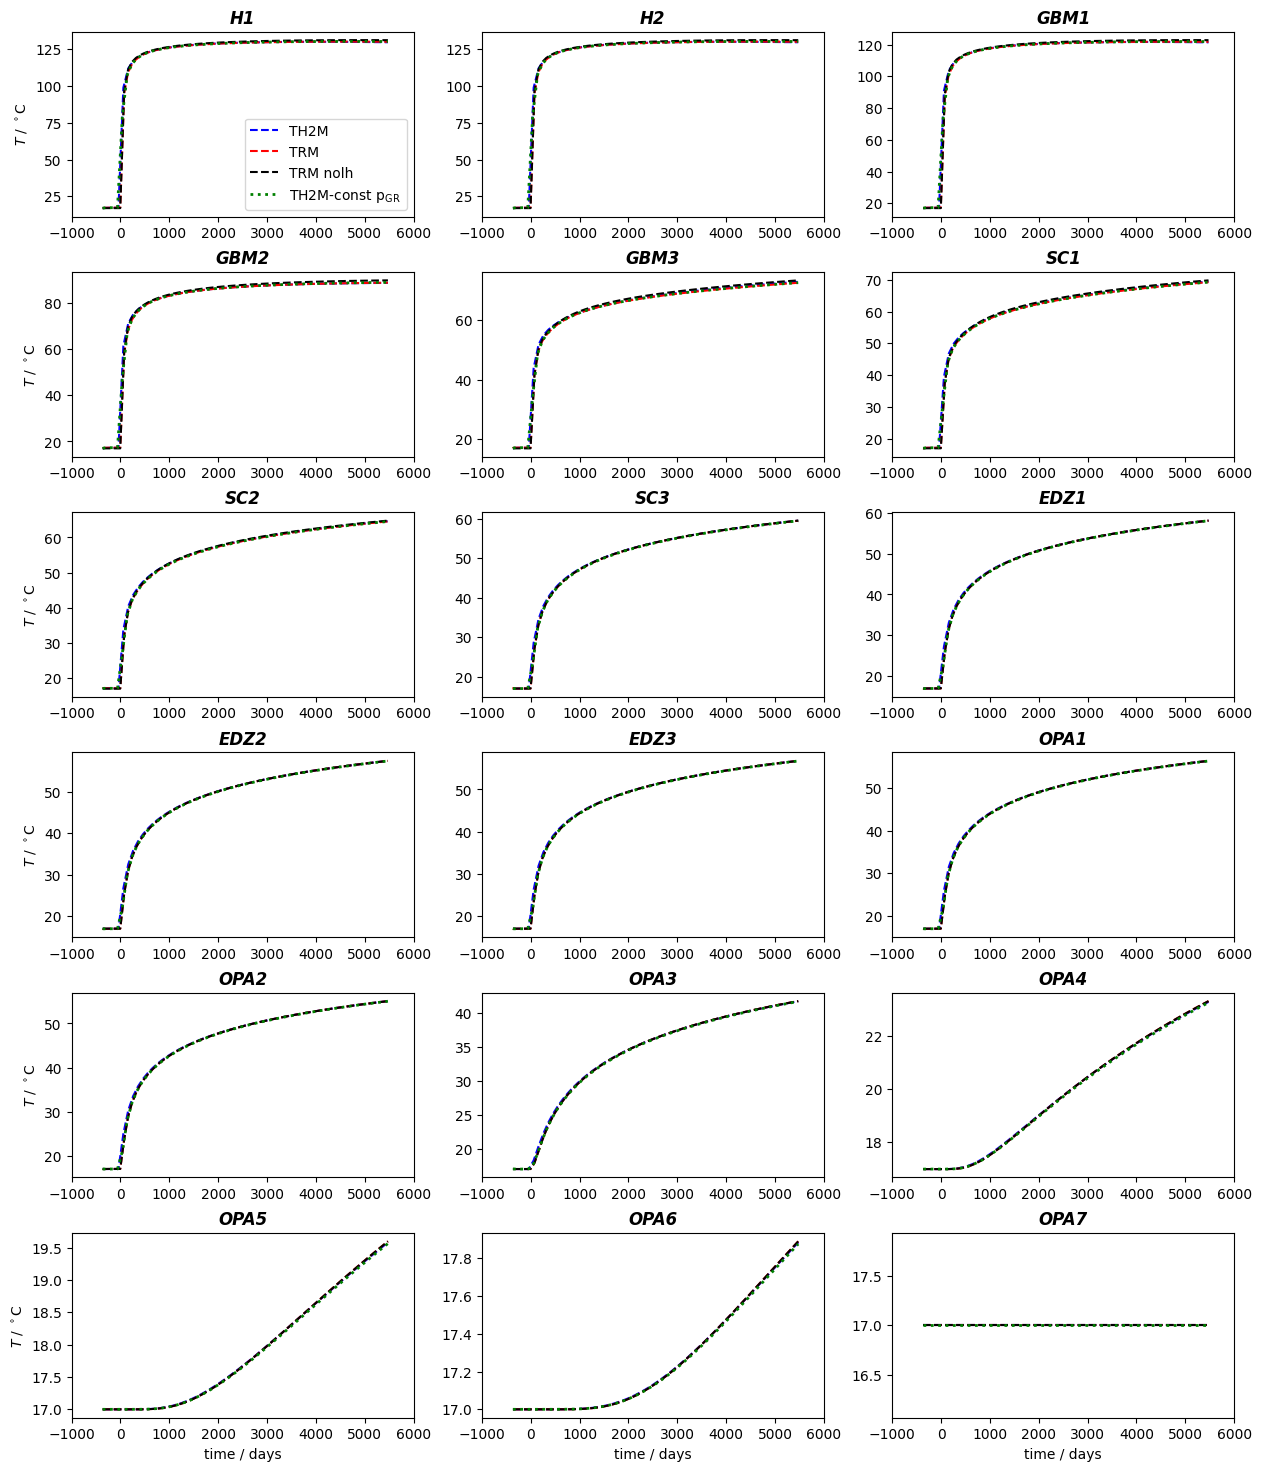

In [52]:
plot_page(-1000,6000, "temperature")

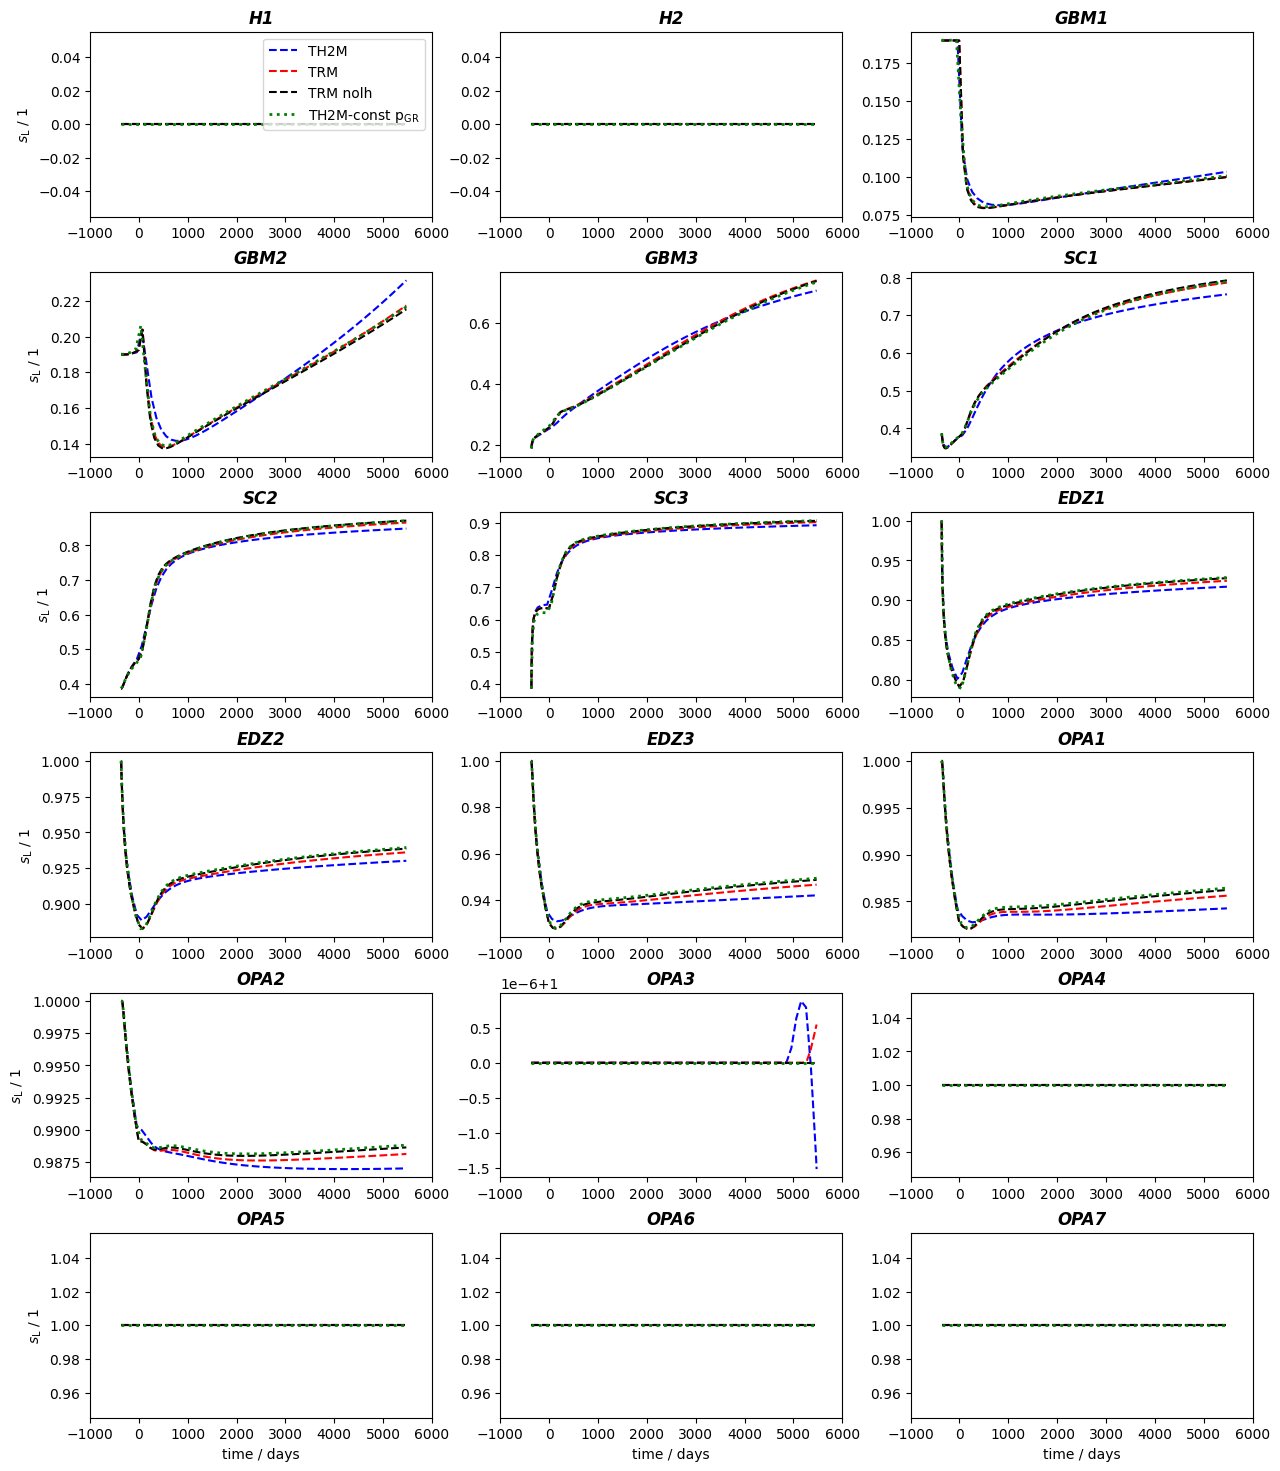

In [53]:
plot_page(-1000,6000, "saturation")

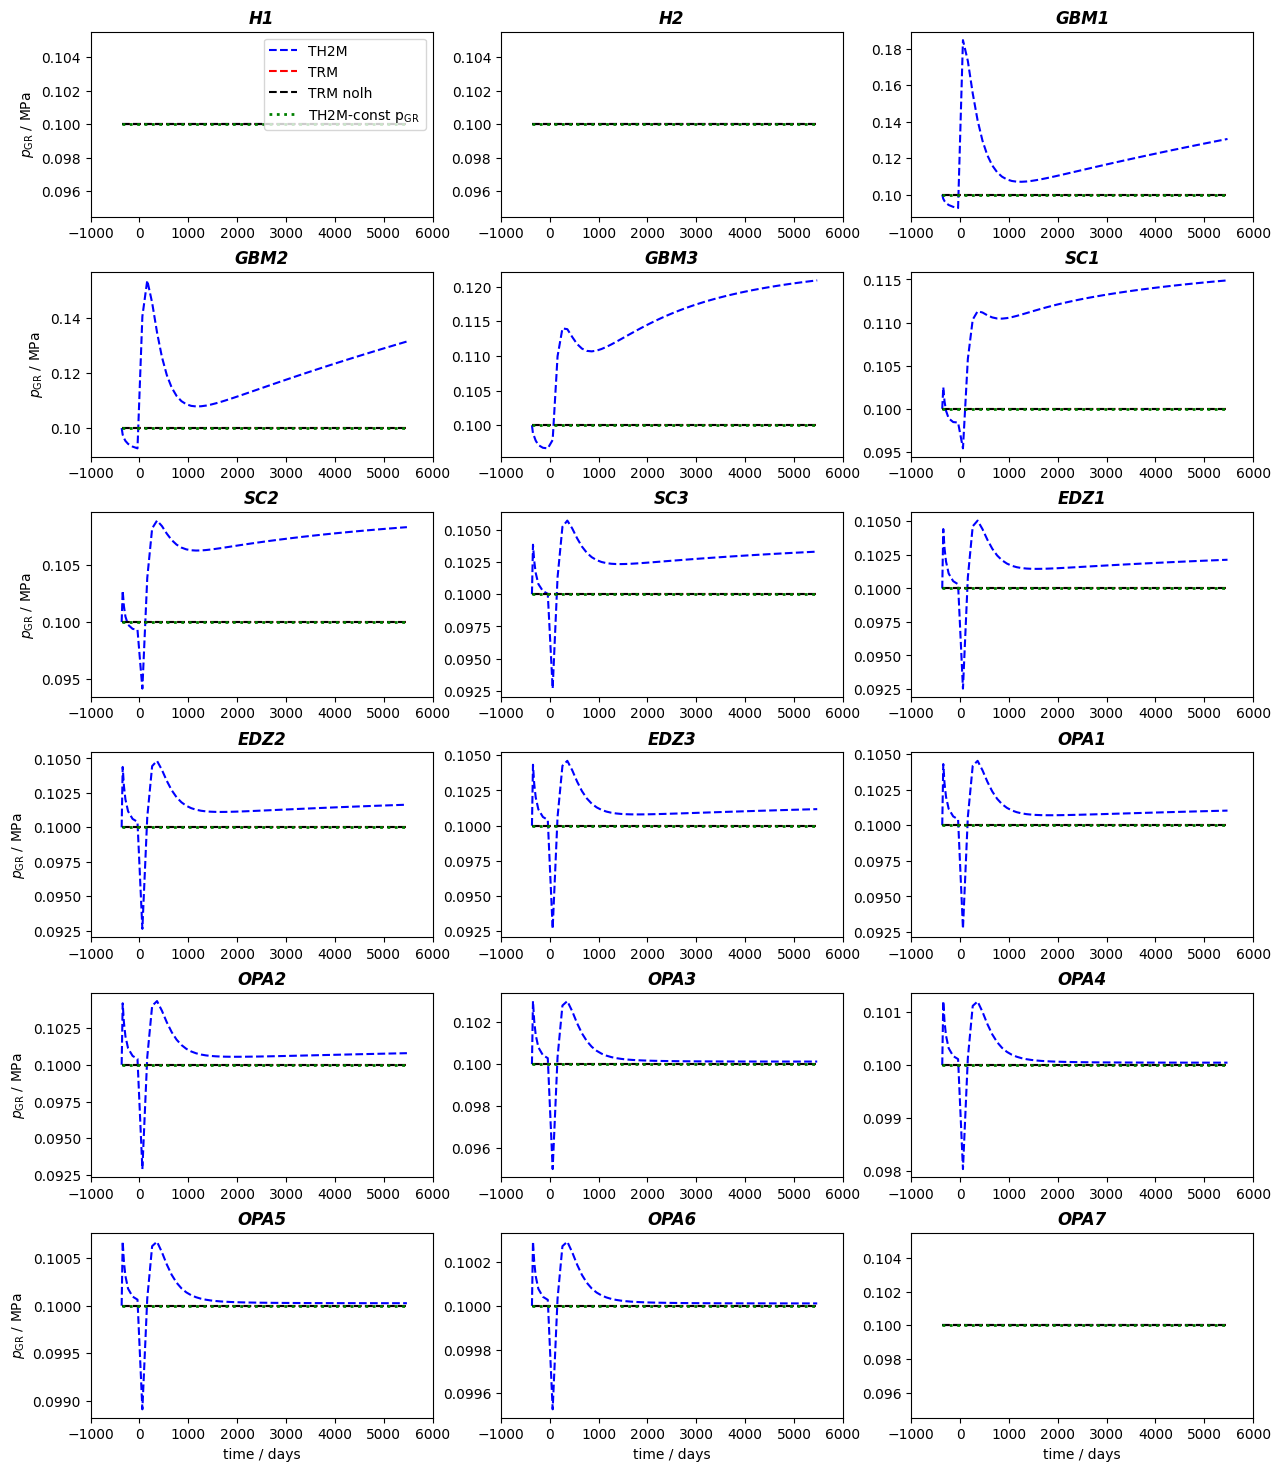

In [54]:
plot_page(-1000,6000, "gas_pressure")

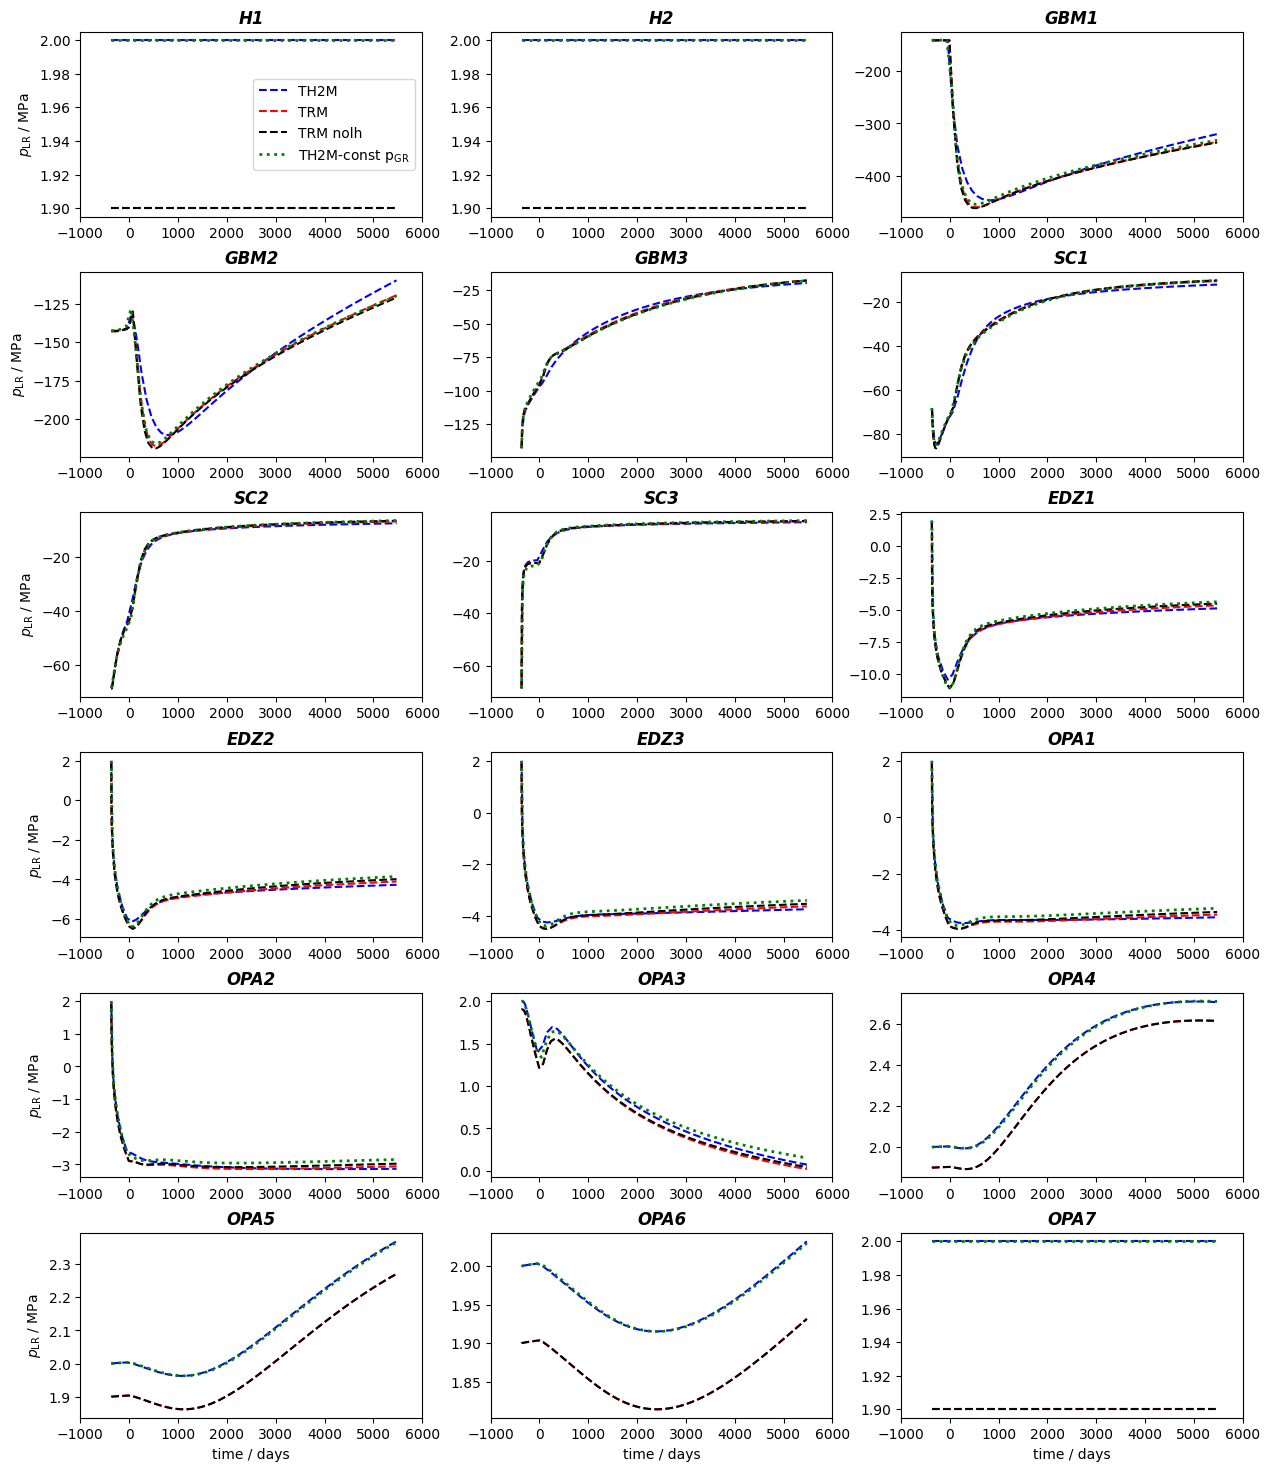

In [55]:
plot_page(-1000,6000, "liquid_pressure")

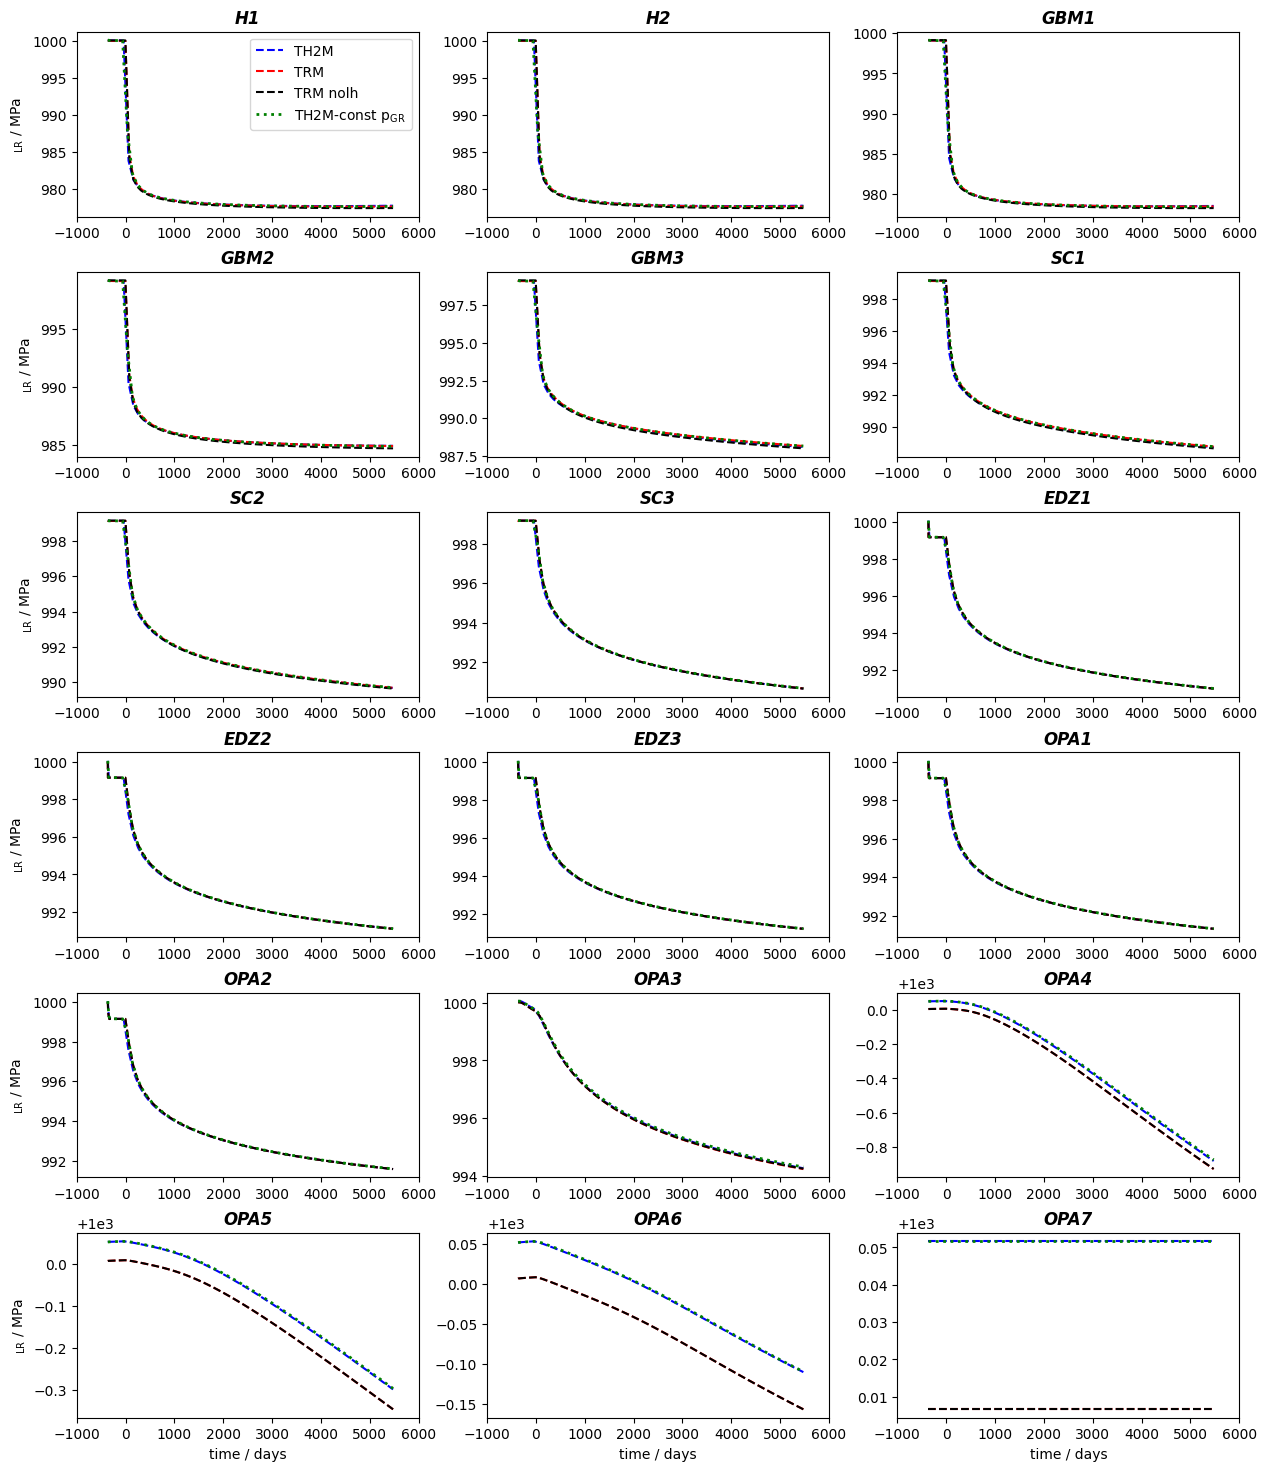

In [56]:
plot_page(-1000,6000, "liquid_density")

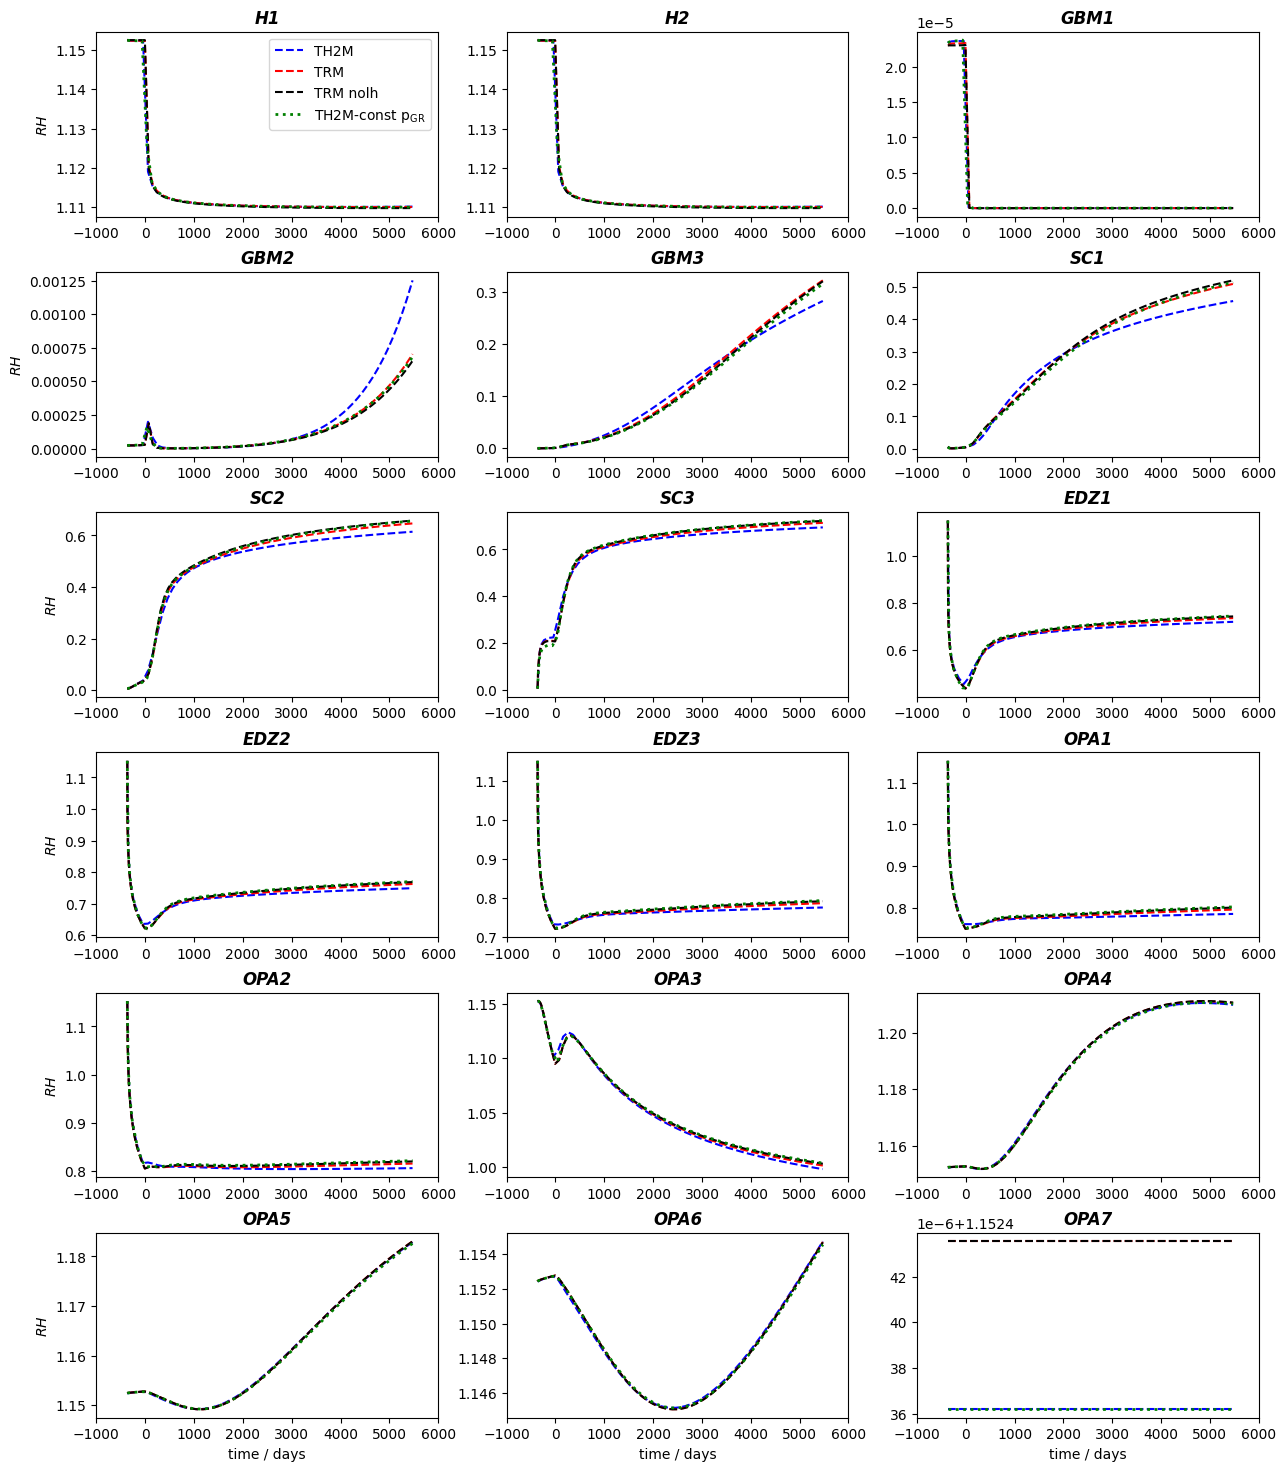

In [57]:
plot_page(-1000,6000, "relative_humidity")

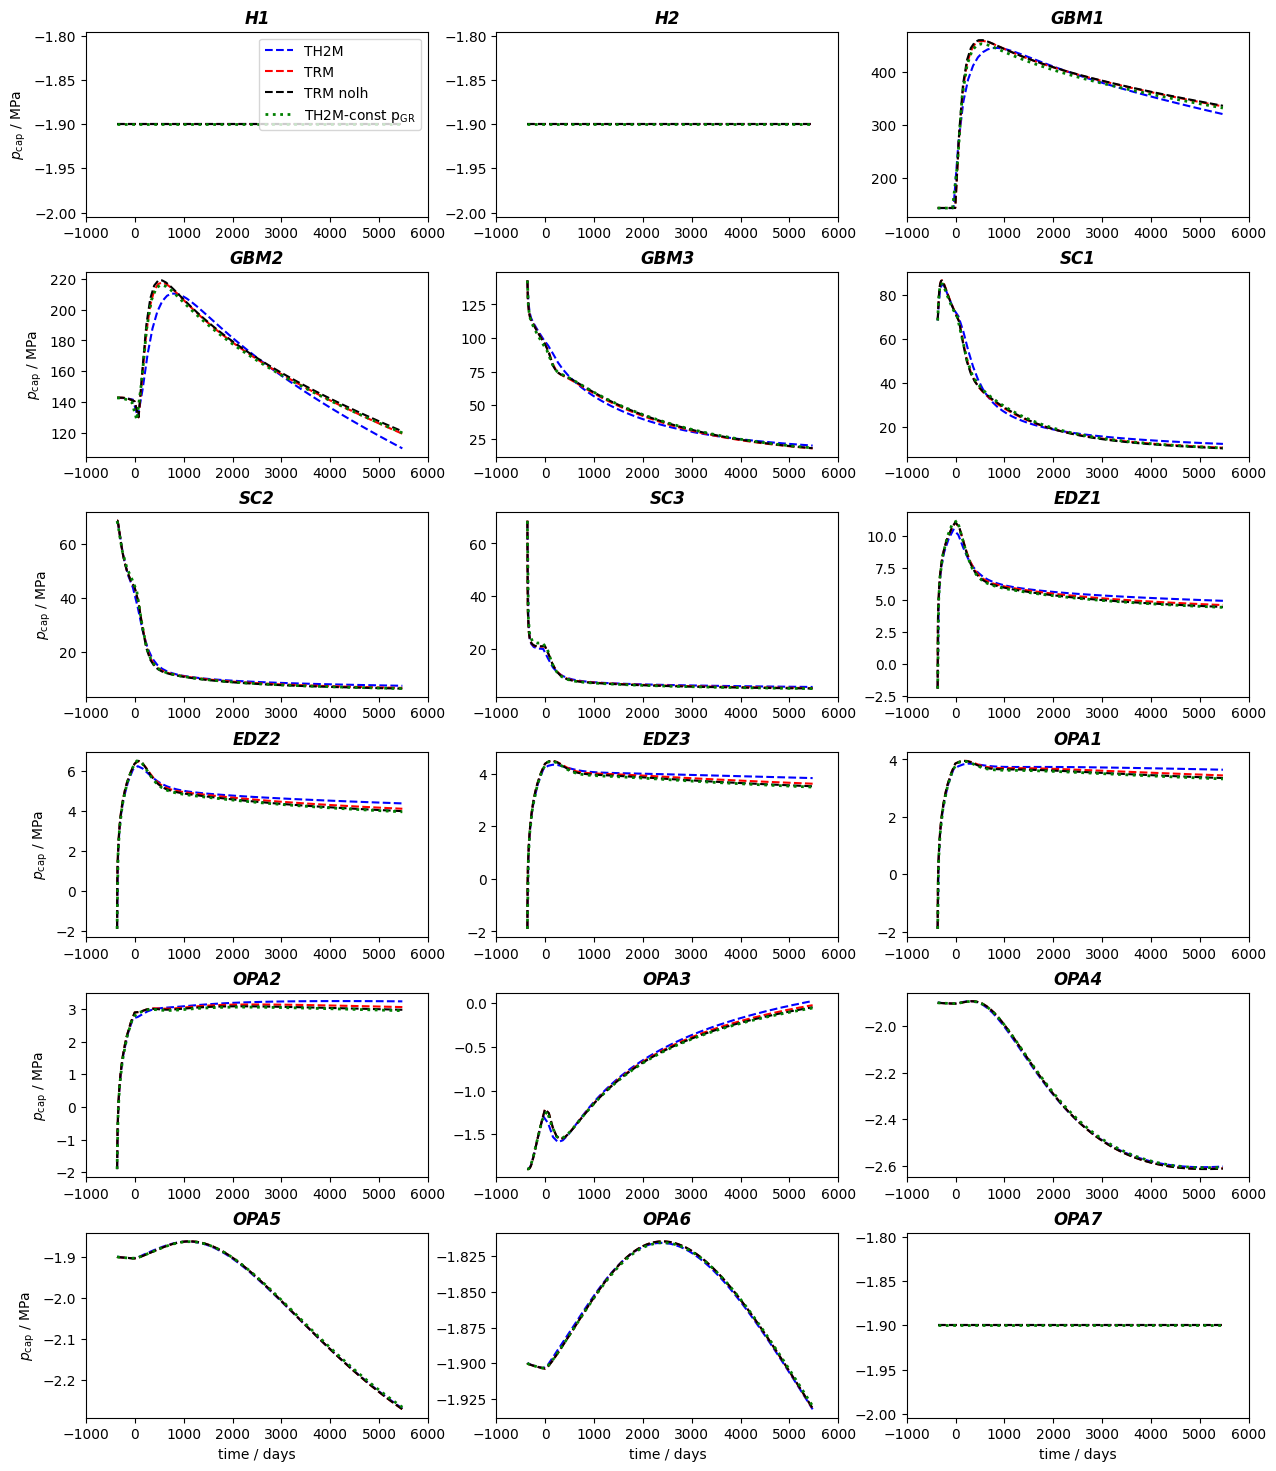

In [58]:
plot_page(-1000,6000, "capillary_pressure")